# Bank Telemarketing Campaign - Opening Deposit Classification

### Context 

Term Deposit adalah investasi deposito keuangan dengan jangka waktu tertentu pada sebuah institusi keuangan/bank. Term Deposit Investment berkisar antara 1 bulan hingga beberapa tahun dan memiliki nilai minimum yang berbeda - beda. Dengan bantuan telemarketing, bank dapat memasarkan berbagai macam produk dan jasanya secara langsung kepada customer. 

Sebuah Bank di Portugal ingin menawarkan term deposit kepada klien yang mereka hubungi. Bank tersebut memiliki data hasil marketing campaign penawaran term deposit yang ditawarkan melalui telepon. Bank tersebut ingin mengetahui klien mana yang kemungkinan akan tertarik untuk membuka term deposit karena dapat membantu mengurangi biaya dan waktu yang digunakan untuk menghubungi calon nasabah dan melakukan marketing campaign.

Target:

No/0: Tidak setuju untuk membuka term deposit.

Yes/1: Setuju untuk membuka term deposit.

### Problem Statement

Telemarketing merupakan cara pemasaran produk yang banyak digunakan banyak perusahaan di berbagai macam industri saat ini. Strategi Telemarketing dinilai mampu meningkatkan pendapatan dan pencapaian target pada bank dikarenakan lebih efisien dari segi waktu dan jarak. 
Bank ingin melakukan telemarketing ke klien yang kemungkinan besar akan membuka term deposit. Jika telemarketing dilakukan pada seluruh kandidat, maka biaya tersebut akan menjadi sia-sia jika kandidat tersebut tidak tertarik untuk membuka term deposit.

### Goals 

Berdasarkan permasalahan tersebut, bank ingin memprediksi kemungkinan seorang klien akan membuka term deposit atau tidak. Penyaringan dapat dilakukan dengan memprediksi kemungkinan tersebut sehingga bank dapat mengurangi biaya telemarketing campaign terkait dengan term deposit. Selain itu pihak marketing bank juga ingin dapat mengoptimalkan potensi klien yang akan membuka term deposit. 

### Analytic Approach

Melakukan menganalisis pada data untuk menemukan pola yang membedakan klien yang akan membuka term deposit dan yang tidak.
Kemudian akan dibangun model klasifikasi yang akan membantu tim marketing bank untuk dapat memprediksi probabilitas seorang klien akan membuka term deposit atau tidak.

### Metric Evaluation

<img src='matrix.PNG'>

* Type I Error (False Positive) : Kerugian waktu dan sumber daya dalam melakukan telemarketing
* Type II Error (False Negative) : Kehilangan calon klien potensial

Berdasarkan konsekuensi tersebut, model yang dibuat diharapkan dapat mengurangi biaya telemarketing tanpa terlalu banyak kehilangan klien potensial yang akan membuka term deposit. Metric utama yang akan digunakan adalah f1-score untuk menyeimbangkan precision dan recall dari kelas positive (calon potensial).

## Data Understanding

Dataset source: https://www.kaggle.com/datasets/volodymyrgavrysh/bank-marketing-campaigns-dataset

Note : 
- Dataset tidak seimbang
- Sebagian besar fitur bersifat kategori (Nominal, Ordinal, Binary)
- Setiap baris data merepresentasikan informasi klien yang dilakukan telemarketing campaign sebelumnya
- Informasi pada kolom `duration` tidak diketahui sebelum proses telemarketing dilakukan, sehingga kolom tersebut dianjurkan untuk tidak digunakan sebagai fitur pada model prediksi

### Attribute Information

| Attribute | Data Type| Description |
| --- | --- | --- |
| age | int64 | Client's age |
| job | object | Type of job |
| marital | object | Marital status |
| education | object | Education of client |
| default | object | Has credit in default? |
| housing | object | Has housing loan? |
| loan  | object | Has personal loan? |
| contact | object | Contact communication type |
| month | object | Last contact month of year |
| day_of_week | object | Last contact day of the week |
| duration | int64 | Last contact duration, in seconds |
| campaign | int64 | Number of contacts performed during this campaign and for this client |
| pdays | Long | Number of days that passed by after the client was last contacted from a previous campaign |
| previous | int64 | Number of contacts performed before this campaign and for this client  |
| poutcome | object | Outcome of the previous marketing campaign |
| emp.var.rate | float64 | Employment variation rate - quarterly indicator |
| cons.price.idx | float64 | Consumer price index - monthly indicator |
| cons.conf.idx | float64 | Consumer confidence index - monthly indicator |
| euribor3m | float64 | Euribor 3 month rate - daily indicator |
| nr.employed | float64 | Number of employees - quarterly indicator |
| y | object | Has the client subscribed a term deposit? ("yes"/"no") |

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline, make_pipeline
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, plot_roc_curve, f1_score, roc_auc_score, recall_score, accuracy_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
df = pd.read_csv('bank-additional-full.csv', sep=';')
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [3]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,age,int64,0,0.0,78,"[66, 56]"
1,job,object,0,0.0,12,"[entrepreneur, management]"
2,marital,object,0,0.0,4,"[unknown, single]"
3,education,object,0,0.0,8,"[university.degree, unknown]"
4,default,object,0,0.0,3,"[no, unknown]"
5,housing,object,0,0.0,3,"[no, unknown]"
6,loan,object,0,0.0,3,"[yes, no]"
7,contact,object,0,0.0,2,"[cellular, telephone]"
8,month,object,0,0.0,10,"[mar, may]"
9,day_of_week,object,0,0.0,5,"[mon, tue]"


Dalam dataset ini missing data ditulis sebagai unknown. Untuk EDA dan modeling nilai unknown akan dikategorikan sebagai kategori tersendiri, sehingga tidak ada missing value. Hal tersebut diasumsikan klien tidak ingin memberikan informasi tertentu.

In [4]:
# mengubah kolom target kedalam bentuk numerikal
df['y'] = np.where(df['y'] == 'no', 0, 1)

## Feature Engineering

### Binning

In [5]:
campaign_cat = []
for val in df['campaign']:
    if val in range(1,4):
        val = '=<4 calls'
        campaign_cat.append(val)
    elif val in range(4,8):
        val = '4-8 calls'
        campaign_cat.append(val)
    else:
        val = '>8 calls'
        campaign_cat.append(val)

In [6]:
df['campaign'] = campaign_cat

Kolom `campaign` diubah ke bentuk kategorikal agar proporsi datanya menjadi lebih merata

Selanjutnya akan kita lihat korelasinya dengan kolom target.

In [7]:
print("Independence test untuk kolom campaign dan y(target) : ")
alpha = 0.05
stat, p, dof, expected = chi2_contingency(pd.crosstab(df['campaign'], df['y']))
print(f"p value is " + str(p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 true)')

Independence test untuk kolom campaign dan y(target) : 
p value is 2.87502219062557e-38
Dependent (reject H0)


Kolom `emp.var.rate`, `cons.price.idx`,`cons.conf.idx`, `euribor3m`, `nr.employed` juga dapat dapat diubah kedalam bentuk kategorikal

In [8]:
for col in ['emp.var.rate', 'cons.price.idx','cons.conf.idx', 'euribor3m', 'nr.employed']:
    print(f"jumlah nilai unik sebanyak : {df[col].nunique()}")
print(f"jumlah data sebanyak : {len(df)}")

jumlah nilai unik sebanyak : 10
jumlah nilai unik sebanyak : 26
jumlah nilai unik sebanyak : 26
jumlah nilai unik sebanyak : 316
jumlah nilai unik sebanyak : 11
jumlah data sebanyak : 41188


dapat kita lihat bahwa dari 5 kolom numerik tersebut tidak memiliki nilai yang terlalu beragam dibandingkan dengan jumlah datanya. Maka dari itu masing - masing kolom dapat kita ubah ke bentuk kategorikal dengan 4 interval dan bersifat ordinal. 

In [9]:
df['emp.var.rate'] = pd.cut(df['emp.var.rate'], bins=4, labels=False)
df['cons.conf.idx'] = pd.cut(df['cons.conf.idx'], bins=4, labels=False)
df['cons.price.idx'] = pd.cut(df['cons.price.idx'], bins=4, labels=False)
df['nr.employed'] = pd.cut(df['nr.employed'], bins=4, labels=False)
df['euribor3m'] = pd.cut(df['euribor3m'], bins=4, labels=False)

Selanjutnya akan kita lihat korelasinya dengan kolom target.

In [10]:
binning_cols = ['emp.var.rate', 'cons.conf.idx', 'cons.price.idx', 'nr.employed', 'euribor3m']
for col in binning_cols:
    print(f"Independence test untuk kolom {col} dan y(target) : ")
    alpha = 0.05
    stat, p, dof, expected = chi2_contingency(pd.crosstab(df[col], df['y']))
    print(f"p value is " + str(p))
    if p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (H0 true) ==> X')
    print('-------------------------')

Independence test untuk kolom emp.var.rate dan y(target) : 
p value is 0.0
Dependent (reject H0)
-------------------------
Independence test untuk kolom cons.conf.idx dan y(target) : 
p value is 0.0
Dependent (reject H0)
-------------------------
Independence test untuk kolom cons.price.idx dan y(target) : 
p value is 0.0
Dependent (reject H0)
-------------------------
Independence test untuk kolom nr.employed dan y(target) : 
p value is 0.0
Dependent (reject H0)
-------------------------
Independence test untuk kolom euribor3m dan y(target) : 
p value is 0.0
Dependent (reject H0)
-------------------------


Untuk kolom `pdays` dan `previous` dapat kita ubah ke kategori 1 dan 0.

In [11]:
print(f"Persentase klien yang tidak pernah dihubungi di campaign sebelumnya: {len(df[df['pdays'] == 999])*100/len(df)}%")
print(f"Persentase klien pernah dihubungi di campaign sebelumnya: {len(df[df['pdays'] != 999])*100/len(df)}%")
print(f"Jumlah data klien seluruhnya: {len(df)}")

Persentase klien yang tidak pernah dihubungi di campaign sebelumnya: 96.32174419733903%
Persentase klien pernah dihubungi di campaign sebelumnya: 3.6782558026609693%
Jumlah data klien seluruhnya: 41188


In [12]:
df['pdays'] = np.where(df['pdays'] == 999, 0, 1)
df['previous'] = np.where(df['previous'] >= 1, 1, 0)

In [13]:
for i in df.drop(columns=['age', 'duration', 'y', 'housing', 'loan']).columns:
    relevent_experience_df = df.groupby(i)['y'].value_counts(normalize=True).unstack()
    display(relevent_experience_df.sort_values(by=[1.0], ascending=False))

y,0,1
job,,
student,0.685714,0.314286
retired,0.747674,0.252326
unemployed,0.857988,0.142012
admin.,0.870274,0.129726
management,0.887825,0.112175
unknown,0.887879,0.112121
technician,0.891740,0.108260
self-employed,0.895144,0.104856
housemaid,0.900000,0.100000


y,0,1
marital,,
unknown,0.850000,0.150000
single,0.859959,0.140041
divorced,0.896791,0.103209
married,0.898427,0.101573


y,0,1
education,,
illiterate,0.777778,0.222222
unknown,0.854997,0.145003
university.degree,0.862755,0.137245
professional.course,0.886515,0.113485
high.school,0.891645,0.108355
basic.4y,0.897510,0.102490
basic.6y,0.917976,0.082024
basic.9y,0.921754,0.078246


y,0,1
default,,
no,0.87121,0.12879
unknown,0.94847,0.05153
yes,1.00000,NaN


y,0,1
contact,,
cellular,0.852624,0.147376
telephone,0.947687,0.052313


y,0,1
month,,
mar,0.494505,0.505495
dec,0.510989,0.489011
sep,0.550877,0.449123
oct,0.561281,0.438719
apr,0.795213,0.204787
aug,0.893979,0.106021
jun,0.894885,0.105115
nov,0.898561,0.101439
jul,0.909534,0.090466


y,0,1
day_of_week,,
thu,0.878812,0.121188
tue,0.882200,0.117800
wed,0.883329,0.116671
fri,0.891913,0.108087
mon,0.900517,0.099483


y,0,1
campaign,,
=<4 calls,0.878252,0.121748
4-8 calls,0.917719,0.082281
>8 calls,0.958920,0.041080


y,0,1
pdays,,
1,0.361716,0.638284
0,0.907418,0.092582


y,0,1
previous,,
1,0.733511,0.266489
0,0.911678,0.088322


y,0,1
poutcome,,
success,0.348871,0.651129
failure,0.857714,0.142286
nonexistent,0.911678,0.088322


y,0,1
emp.var.rate,,
0,0.609085,0.390915
1,0.795600,0.204400
2,0.936908,0.063092
3,0.953911,0.046089


y,0,1
cons.price.idx,,
0,0.603362,0.396638
3,0.875000,0.125000
1,0.892537,0.107463
2,0.926121,0.073879


y,0,1
cons.conf.idx,,
3,0.609995,0.390005
0,0.859847,0.140153
1,0.907706,0.092294
2,0.917122,0.082878


y,0,1
euribor3m,,
1,0.544118,0.455882
0,0.756515,0.243485
2,0.928571,0.071429
3,0.951655,0.048345


y,0,1
nr.employed,,
0,0.510754,0.489246
1,0.642814,0.357186
2,0.872041,0.127959
3,0.951643,0.048357


## Data Analysis

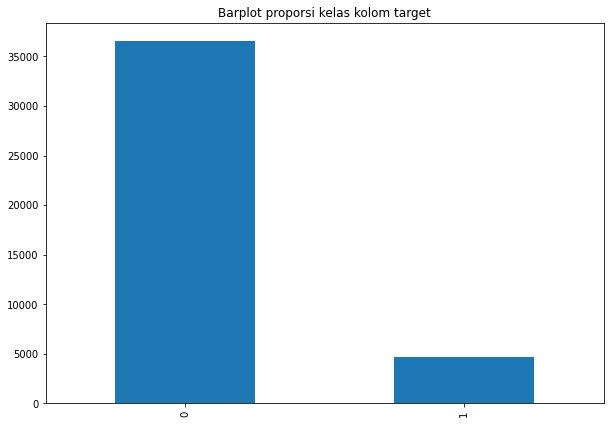

In [14]:
plt.figure(figsize=(10,7))
df['y'].value_counts().plot(kind='bar')
plt.title('Barplot proporsi kelas kolom target');

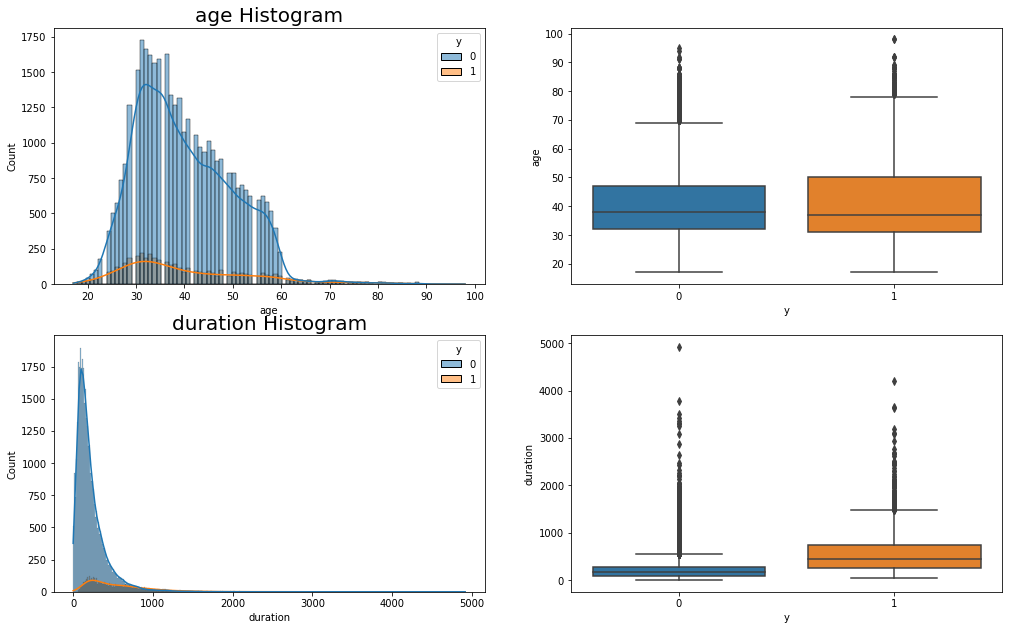

In [15]:
plt.figure(figsize=(17,50))
count = 0


for i in df.drop(columns=['job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'poutcome', 'pdays', 'previous', 
        'emp.var.rate', 'cons.conf.idx', 'cons.price.idx', 'nr.employed', 'euribor3m','campaign', 'y']).columns:
       count +=1
       plt.subplot(9,2,count)
       sns.histplot(data=df,x=i ,hue='y',kde=True)
       plt.title('{} Histogram'.format(i),fontsize=20)

       count +=1
       plt.subplot(9,2,count)
       sns.boxplot(data=df,y=i, x='y')

plt.show()

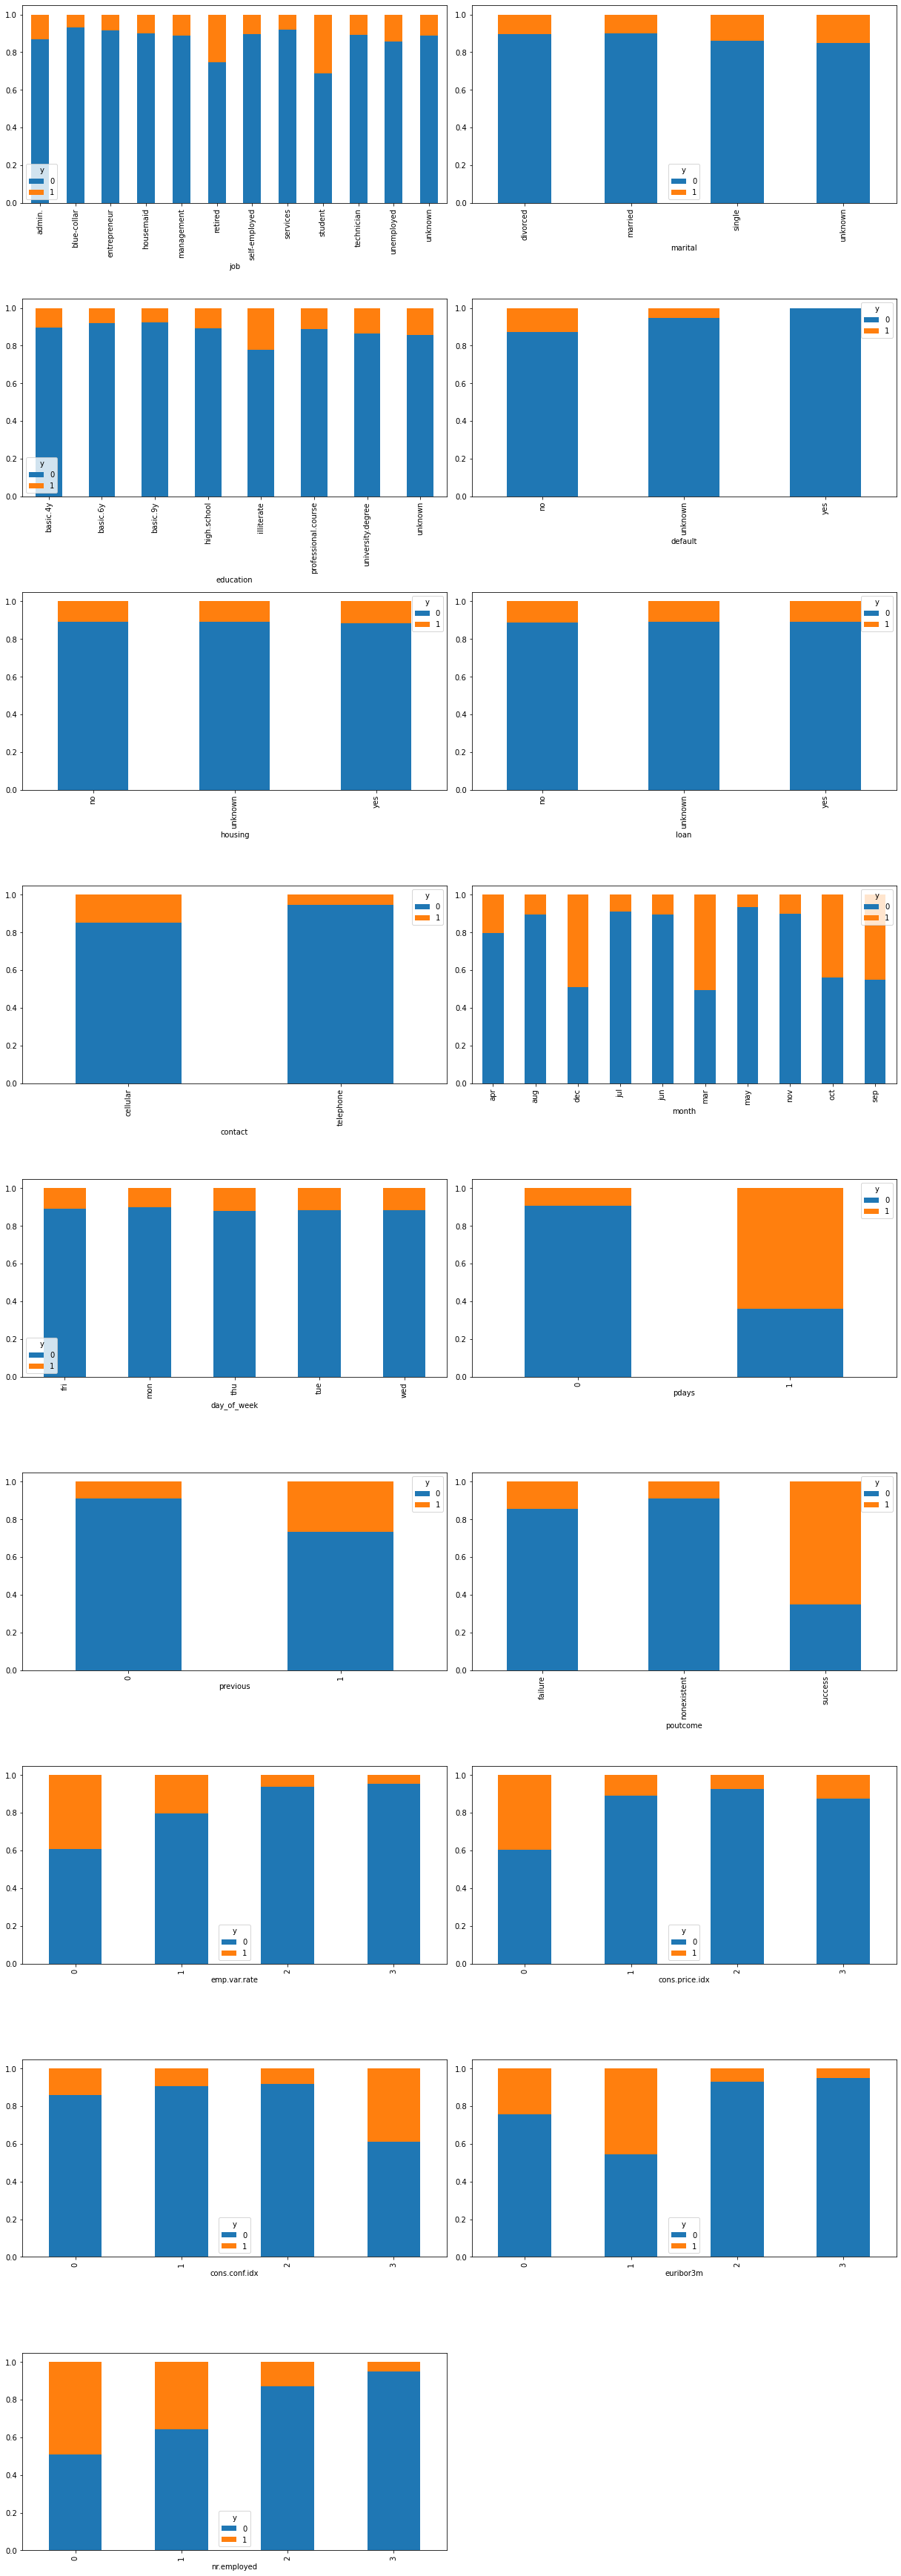

In [16]:
count = 0
fig = plt.figure(figsize=(17,70))

for i in df.drop(columns=['age', 'duration', 'campaign', 'y']).columns:
    count +=1
    ax= plt.subplot(13,2,count)
    pd.crosstab(df[i],df['y'],normalize=0).plot(kind='bar',stacked=True,ax=ax)
    fig.tight_layout()

plt.show()

In [17]:
for i in df.drop(columns=['age', 'duration', 'y', 'housing', 'loan']).columns:
    relevent_experience_df = df.groupby(i)['y'].value_counts(normalize=True).unstack()
    display(relevent_experience_df.sort_values(by=[1.0], ascending=False))

y,0,1
job,,
student,0.685714,0.314286
retired,0.747674,0.252326
unemployed,0.857988,0.142012
admin.,0.870274,0.129726
management,0.887825,0.112175
unknown,0.887879,0.112121
technician,0.891740,0.108260
self-employed,0.895144,0.104856
housemaid,0.900000,0.100000


y,0,1
marital,,
unknown,0.850000,0.150000
single,0.859959,0.140041
divorced,0.896791,0.103209
married,0.898427,0.101573


y,0,1
education,,
illiterate,0.777778,0.222222
unknown,0.854997,0.145003
university.degree,0.862755,0.137245
professional.course,0.886515,0.113485
high.school,0.891645,0.108355
basic.4y,0.897510,0.102490
basic.6y,0.917976,0.082024
basic.9y,0.921754,0.078246


y,0,1
default,,
no,0.87121,0.12879
unknown,0.94847,0.05153
yes,1.00000,NaN


y,0,1
contact,,
cellular,0.852624,0.147376
telephone,0.947687,0.052313


y,0,1
month,,
mar,0.494505,0.505495
dec,0.510989,0.489011
sep,0.550877,0.449123
oct,0.561281,0.438719
apr,0.795213,0.204787
aug,0.893979,0.106021
jun,0.894885,0.105115
nov,0.898561,0.101439
jul,0.909534,0.090466


y,0,1
day_of_week,,
thu,0.878812,0.121188
tue,0.882200,0.117800
wed,0.883329,0.116671
fri,0.891913,0.108087
mon,0.900517,0.099483


y,0,1
campaign,,
=<4 calls,0.878252,0.121748
4-8 calls,0.917719,0.082281
>8 calls,0.958920,0.041080


y,0,1
pdays,,
1,0.361716,0.638284
0,0.907418,0.092582


y,0,1
previous,,
1,0.733511,0.266489
0,0.911678,0.088322


y,0,1
poutcome,,
success,0.348871,0.651129
failure,0.857714,0.142286
nonexistent,0.911678,0.088322


y,0,1
emp.var.rate,,
0,0.609085,0.390915
1,0.795600,0.204400
2,0.936908,0.063092
3,0.953911,0.046089


y,0,1
cons.price.idx,,
0,0.603362,0.396638
3,0.875000,0.125000
1,0.892537,0.107463
2,0.926121,0.073879


y,0,1
cons.conf.idx,,
3,0.609995,0.390005
0,0.859847,0.140153
1,0.907706,0.092294
2,0.917122,0.082878


y,0,1
euribor3m,,
1,0.544118,0.455882
0,0.756515,0.243485
2,0.928571,0.071429
3,0.951655,0.048345


y,0,1
nr.employed,,
0,0.510754,0.489246
1,0.642814,0.357186
2,0.872041,0.127959
3,0.951643,0.048357



Berdasarkan barplot dan table di atas, dapat disimpulkan beberapa hal sebagai berikut:
<br>
1. Pada atribut `job`, client yang memiliki jenis pekerjaan `student` cenderung lebih setuju untuk membuka term deposit dibandingkan `Job` yang lain.
2. Pada atribut `marital`, client yang `single` dan `unknown` cenderung lebih setuju untuk membuka term deposit dibandingkan `marital` yang lain.
3. Pada atribut `education`, client yang memiliki tingkat pendidikan `illiterate` memiliki kecenderungan untuk membuka term deposit terbesar dibandingkan yang lainnya, namun jumlah samplenya sangat kecil (10 orang). Sehingga client yang memiliki kecenderungan untuk membuka term deposit terbesar adalah `unknown` dan `university.degree`.
4. Pada atribut `default`, client yang belum pernah mengalami kredit macet atau _default_ (`no`) cenderung lebih setuju untuk membuka term deposit dibandingkan client yang pernah mengalami kredit macet (`yes`). Seluruh client yang pernah mengalami kredit macet (`yes`) juga pasti memilih untuk menolak membuka term deposit.
5. Pada atribut `housing`, client yang memiliki _housing loan_ (`yes`) cenderung lebih setuju untuk membuka term deposit dibandingkan dengan client yang tidak memiliki _housing loan_ (`no`) dan `unknown`, namun perbedaan antara ketiganya sangat tipis.
6. Pada atribut `housing`, client yang tidak memiliki _personal loan_ (`no`) cenderung lebih setuju untuk membuka term deposit dibandingkan dengan client yang memiliki _personal loan_ (`yes`) dan `unknown`, namun perbedaan antara ketiganya sangat tipis.
7. Pada atribut `month`, client dengan _last contact_ pada bulan maret (`mar`) cenderung lebih setuju untuk membuka term deposit dibandingkan dengan bulan lainnya.
8. Pada atribut `day_of_week`, client dengan _last contact_ pada hari kamis (`thu`) cenderung lebih setuju untuk membuka term deposit, walaupun hari kamis (`thu`), selasa (`tue`), dan rabu (`wed`) perbedaannya sangat tipis.
9. Pada atribut `campaign`, client yang ditelfon kurang dari sama dengan 4 kali pada _marketing campaign_ sebelumnya (`=<4`) cenderung lebih setuju untuk membuka term deposit dibandingkan dengan `campaign` yang lain.
10. Pada atribut `poutcome`, client yang setuju pada _marketing campaign_ sebelumnya (`success`) cenderung lebih setuju untuk membuka term deposit dibandingkan dengan `poutcome` yang lain.

## Hypothesis Testing

Selanjutnya akan kita lakukan chi squared test untuk melihat apakah masing - masing fitur berhubungan secara dependen atau independen terhadap kolom target.

Membandingkan p value dari kolom kategorikal terhadap target dengan alpha (a = 0.05). Jika p-value lebih kecil atau samadengan alpha, maka kolom kategorikal tersebut berhubungan secara dependen dengan kolom target. Jika p-value lebih besar dari alpha, maka kolom kategorikal tersebut berhubungan secara independen dengan kolom target.

In [18]:
from scipy.stats import chi2_contingency

for col in df.drop(columns=['age', 'duration']).columns:
    print(f"Independence test untuk kolom {col} dan y(target) : ")
    alpha = 0.05
    stat, p, dof, expected = chi2_contingency(pd.crosstab(df[col], df['y']))
    print(f"p value is " + str(p))
    if p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (H0 true) ==> X')
    print('-------------------------')

Independence test untuk kolom job dan y(target) : 
p value is 4.189763287563623e-199
Dependent (reject H0)
-------------------------
Independence test untuk kolom marital dan y(target) : 
p value is 2.068014648442211e-26
Dependent (reject H0)
-------------------------
Independence test untuk kolom education dan y(target) : 
p value is 3.3051890144025054e-38
Dependent (reject H0)
-------------------------
Independence test untuk kolom default dan y(target) : 
p value is 5.1619579513916376e-89
Dependent (reject H0)
-------------------------
Independence test untuk kolom housing dan y(target) : 
p value is 0.05829447669453452
Independent (H0 true) ==> X
-------------------------
Independence test untuk kolom loan dan y(target) : 
p value is 0.5786752870441754
Independent (H0 true) ==> X
-------------------------
Independence test untuk kolom contact dan y(target) : 
p value is 1.5259856523129964e-189
Dependent (reject H0)
-------------------------
Independence test untuk kolom month dan y

kolom `housing` dan `loan` independen terhadap kolom target.

Berdasarkan independence test kita dapat tidak mengikutsertakan kolom `housing` dan `loan` untuk modeling. Kolom `duration` juga tidak relevan untuk dijadikan fitur karena data terkait lama waktu telemarketing dapat diketahui apabila telemarketing telah dilakukan, sedangkan dalam membuat predictive model tidak perlu dilakukan telemarketing terlebih dahulu.

In [19]:
df.drop(columns=['duration', 'housing', 'loan'], inplace=True)
df

,age,job,marital,education,default,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,telephone,may,mon,=<4 calls,0,0,nonexistent,3,2,2,3,3,0
1,57,services,married,high.school,unknown,telephone,may,mon,=<4 calls,0,0,nonexistent,3,2,2,3,3,0
2,37,services,married,high.school,no,telephone,may,mon,=<4 calls,0,0,nonexistent,3,2,2,3,3,0
3,40,admin.,married,basic.6y,no,telephone,may,mon,=<4 calls,0,0,nonexistent,3,2,2,3,3,0
4,56,services,married,high.school,no,telephone,may,mon,=<4 calls,0,0,nonexistent,3,2,2,3,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,cellular,nov,fri,=<4 calls,0,0,nonexistent,1,3,0,0,0,1
41184,46,blue-collar,married,professional.course,no,cellular,nov,fri,=<4 calls,0,0,nonexistent,1,3,0,0,0,0
41185,56,retired,married,university.degree,no,cellular,nov,fri,=<4 calls,0,0,nonexistent,1,3,0,0,0,0
41186,44,technician,married,professional.course,no,cellular,nov,fri,=<4 calls,0,0,nonexistent,1,3,0,0,0,1


## Data Preprocessing and Data Splitting

* Kolom Target : `y`
* Jumlah kolom fitur : 17
* Kolom numerikal : `age`
* Kolom fitur ordinal : `emp.var.rate`, `cons.price.idx`,`cons.conf.idx`, `euribor3m`, `nr.employed`
* kolom fitur one hot encoding : `default`, `previous`, `marital`, `contact`, `day_of_week`, `education`, `job`, `poutcome`, `campaign`, `month`

In [20]:
transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first'), ['default', 'previous', 'marital', 'contact', 'day_of_week', 
                                             'education', 'job', 'poutcome', 'campaign', 'month']),
], remainder='passthrough')

In [21]:
X = df.drop(columns=['y'])
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((32950, 17), (8238, 17), (32950,), (8238,))

## Modeling

In [22]:
logreg = LogisticRegression(max_iter=1000,random_state=20)
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier(random_state=20)
rf = RandomForestClassifier(random_state=20)
xgb = XGBClassifier(random_state=20)
lgbm = lgb.LGBMClassifier(random_state=20)

In [23]:
models = [logreg,knn,dt,rf,xgb,lgbm]
score=[]
rata=[]
std=[]

for i in models:
    skfold=StratifiedKFold(n_splits=5)
    estimator=Pipeline([('preprocess',transformer),('model',i)])
    model_cv=cross_val_score(estimator,X_train,y_train,cv=skfold,scoring='f1')
    score.append(model_cv)
    rata.append(model_cv.mean())
    std.append(model_cv.std())
 
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost', 
                       'LightGBM'],'mean f1-score':rata,'sdev':std}).set_index('model').sort_values(by='mean f1-score',ascending=False)

,mean f1-score,sdev
model,,
LightGBM,0.363812,0.018094
Random Forest,0.353333,0.011576
KNN,0.336033,0.005281
Logistic Regression,0.333459,0.013698
XGBoost,0.324173,0.017124
Decision Tree,0.318954,0.016248


Terlihat bahwa model LightGBM adalah yang terbaik untuk f1-scorenya dari setiap model yang menggunakan default hyperparameter

In [24]:
models = [logreg,knn,dt,rf,xgb,lgbm]
score_f1 = []

def y_pred_func(i):
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',i)])
    X_train,X_test
    
    estimator.fit(X_train,y_train)
    return(estimator,estimator.predict(X_test),X_test)

for i,j in zip(models, ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost','LightGBM']):
    estimator,y_pred,X_test = y_pred_func(i)
    y_predict_proba = estimator.predict_proba(X_test)[:,1]
    score_f1.append(f1_score(y_test,y_pred))
    print(j,'\n', classification_report(y_test,y_pred))
    
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost','LightGBM'],
             'f1 score':score_f1}).set_index('model').sort_values(by='f1 score',ascending=False)

Logistic Regression 
               precision    recall  f1-score   support

           0       0.91      0.99      0.95      7310
           1       0.71      0.23      0.34       928

    accuracy                           0.90      8238
   macro avg       0.81      0.61      0.65      8238
weighted avg       0.89      0.90      0.88      8238

KNN 
               precision    recall  f1-score   support

           0       0.91      0.97      0.94      7310
           1       0.53      0.28      0.37       928

    accuracy                           0.89      8238
   macro avg       0.72      0.63      0.66      8238
weighted avg       0.87      0.89      0.88      8238

Decision Tree 
               precision    recall  f1-score   support

           0       0.92      0.92      0.92      7310
           1       0.34      0.33      0.34       928

    accuracy                           0.85      8238
   macro avg       0.63      0.63      0.63      8238
weighted avg       0.85      0

,f1 score
model,
LightGBM,0.379471
Random Forest,0.371107
KNN,0.370787
Logistic Regression,0.343137
Decision Tree,0.336245
XGBoost,0.314476


Pada test data, model LightGBM memiliki performa yang lebih baik daripada model lainnya dari segi f1-score.

Selanjutnya kita coba melakukan oversampling pada model LightGBM untuk melihat apakah kita bisa meningkatkan f1-score

### Test Oversampling with K-Fold Cross Validation (lgbm)

In [25]:
def calc_train_error(X_train, y_train, model):
#     '''returns in-sample error for already fit model.'''
    predictions = model.predict(X_train)
    predictProba = model.predict_proba(X_train)
    accuracy = accuracy_score(y_train, predictions)
    f1 = f1_score(y_train, predictions, average='macro')
    roc_auc = roc_auc_score(y_train, predictProba[:,1])
    recall = recall_score(y_train, predictions)
    precision = precision_score(y_train, predictions)
    report = classification_report(y_train, predictions)
    return { 
        'report': report, 
        'f1' : f1, 
        'roc': roc_auc, 
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision
    }
    
def calc_validation_error(X_test, y_test, model):
#     '''returns out-of-sample error for already fit model.'''
    predictions = model.predict(X_test)
    predictProba = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average='macro')
    roc_auc = roc_auc_score(y_test, predictProba[:,1])
    recall = recall_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    report = classification_report(y_test, predictions)
    return { 
        'report': report, 
        'f1' : f1, 
        'roc': roc_auc, 
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision
    }
    
def calc_metrics(X_train, y_train, X_test, y_test, model):
#     '''fits model and returns the in-sample error and out-of-sample error'''
    model.fit(X_train, y_train)
    train_error = calc_train_error(X_train, y_train, model)
    validation_error = calc_validation_error(X_test, y_test, model)
    return train_error, validation_error

In [26]:
from sklearn.model_selection import StratifiedKFold

K = 5
kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

X_train_oversample = X_train.copy()
y_train_oversample = y_train.copy()

data = X_train_oversample
target = y_train_oversample

In [27]:
train_errors_without_oversampling = []
validation_errors_without_oversampling = []

train_errors_with_oversampling = []
validation_errors_with_oversampling = []

for train_index, val_index in kf.split(data, target):
    
    # split data
    X_train_over, X_val = data.iloc[train_index], data.iloc[val_index]
    Y_train_over, Y_val = target.iloc[train_index], target.iloc[val_index]
    
    # print(len(X_val), (len(X_train) + len(X_val)))
    ros = RandomOverSampler()

    X_ros, Y_ros = ros.fit_resample(X_train_over, Y_train_over)

    # instantiate model
    lgbm = lgb.LGBMClassifier()
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',lgbm)
    ])

    #calculate errors
    train_error_without_oversampling, val_error_without_oversampling = calc_metrics(X_train_over, Y_train_over, X_val, Y_val, estimator)
    train_error_with_oversampling, val_error_with_oversampling = calc_metrics(X_ros, Y_ros, X_val, Y_val, estimator)
    
    # append to appropriate list
    train_errors_without_oversampling.append(train_error_without_oversampling)
    validation_errors_without_oversampling.append(val_error_without_oversampling)
    
    train_errors_with_oversampling.append(train_error_with_oversampling)
    validation_errors_with_oversampling.append(val_error_with_oversampling)

#### Evaluation Metrics Without Oversampling

In [28]:
listItem = []

for tr,val in zip(train_errors_without_oversampling,validation_errors_without_oversampling) :
    listItem.append([tr['accuracy'],val['accuracy'],tr['roc'],val['roc'],tr['f1'],val['f1'],
                     tr['recall'],val['recall'],tr['precision'],val['precision']])

listItem.append(list(np.mean(listItem,axis=0)))
    
dfEvaluate = pd.DataFrame(listItem, 
                    columns=['Train Accuracy', 
                            'Test Accuracy', 
                            'Train ROC AUC', 
                            'Test ROC AUC', 
                            'Train F1 Score',
                            'Test F1 Score',
                            'Train Recall',
                            'Test Recall',
                            'Train Precision',
                            'Test Precision'])

listIndex = list(dfEvaluate.index)
listIndex[-1] = 'Average'
dfEvaluate.index = listIndex
dfEvaluate

,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train F1 Score,Test F1 Score,Train Recall,Test Recall,Train Precision,Test Precision
0,0.910888,0.902276,0.871865,0.786051,0.693684,0.654730,0.305387,0.246631,0.760268,0.682836
1,0.911077,0.901973,0.874204,0.790009,0.696797,0.663409,0.312458,0.266846,0.754472,0.660000
2,0.910357,0.900607,0.869763,0.784741,0.692263,0.657818,0.304040,0.258760,0.753128,0.646465
3,0.913126,0.896510,0.869419,0.784080,0.704425,0.657233,0.323341,0.270525,0.773570,0.589443
4,0.912026,0.896206,0.874502,0.779997,0.698522,0.639172,0.312900,0.231494,0.769040,0.603509
Average,0.911495,0.899514,0.871951,0.784975,0.697138,0.654472,0.311625,0.254851,0.762095,0.636450


#### Evaluation Metrics With Oversampling

In [29]:
listItem = []

for tr,val in zip(train_errors_with_oversampling,validation_errors_with_oversampling) :
    listItem.append([tr['accuracy'],val['accuracy'],tr['roc'],val['roc'],tr['f1'],val['f1'],
                     tr['recall'],val['recall'],tr['precision'],val['precision']])

listItem.append(list(np.mean(listItem,axis=0)))
    
dfEvaluate = pd.DataFrame(listItem, 
                    columns=['Train Accuracy', 
                            'Test Accuracy', 
                            'Train ROC AUC', 
                            'Test ROC AUC', 
                            'Train F1 Score',
                            'Test F1 Score',
                            'Train Recall',
                            'Test Recall',
                            'Train Precision',
                            'Test Precision'])

listIndex = list(dfEvaluate.index)
listIndex[-1] = 'Average'
dfEvaluate.index = listIndex
dfEvaluate

,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train F1 Score,Test F1 Score,Train Recall,Test Recall,Train Precision,Test Precision
0,0.778559,0.835508,0.877174,0.780085,0.776752,0.679467,0.688585,0.611860,0.839685,0.363200
1,0.781808,0.842337,0.884330,0.783838,0.779391,0.684244,0.677127,0.598383,0.856432,0.374684
2,0.788200,0.840819,0.881754,0.781153,0.786227,0.682298,0.692133,0.597035,0.856742,0.371333
3,0.781198,0.841426,0.876942,0.780478,0.779047,0.686454,0.682527,0.613728,0.850333,0.375618
4,0.781690,0.847648,0.881575,0.787287,0.779704,0.692362,0.686760,0.608345,0.847704,0.387983
Average,0.782291,0.841548,0.880355,0.782568,0.780224,0.684965,0.685427,0.605870,0.850179,0.374563


Hasil evaluation metrics menunjukan bahwa f1-score kelas positif pada model LightGBM setelah oversampling lebih baik dari sebelum dilakukan oversampling

#### Classification Reports Without Oversampling

In [30]:
for rep in validation_errors_without_oversampling :
    print(rep['report'])

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      5848
           1       0.68      0.25      0.36       742

    accuracy                           0.90      6590
   macro avg       0.80      0.62      0.65      6590
weighted avg       0.89      0.90      0.88      6590

              precision    recall  f1-score   support

           0       0.91      0.98      0.95      5848
           1       0.66      0.27      0.38       742

    accuracy                           0.90      6590
   macro avg       0.79      0.62      0.66      6590
weighted avg       0.88      0.90      0.88      6590

              precision    recall  f1-score   support

           0       0.91      0.98      0.95      5848
           1       0.65      0.26      0.37       742

    accuracy                           0.90      6590
   macro avg       0.78      0.62      0.66      6590
weighted avg       0.88      0.90      0.88      6590

              preci

#### Classification Reports With Oversampling

In [31]:
for rep in validation_errors_with_oversampling :
    print(rep['report'])

              precision    recall  f1-score   support

           0       0.95      0.86      0.90      5848
           1       0.36      0.61      0.46       742

    accuracy                           0.84      6590
   macro avg       0.65      0.74      0.68      6590
weighted avg       0.88      0.84      0.85      6590

              precision    recall  f1-score   support

           0       0.94      0.87      0.91      5848
           1       0.37      0.60      0.46       742

    accuracy                           0.84      6590
   macro avg       0.66      0.74      0.68      6590
weighted avg       0.88      0.84      0.86      6590

              precision    recall  f1-score   support

           0       0.94      0.87      0.91      5848
           1       0.37      0.60      0.46       742

    accuracy                           0.84      6590
   macro avg       0.66      0.73      0.68      6590
weighted avg       0.88      0.84      0.86      6590

              preci

Classification report menunjukan bahwa f1-score kelas positif pada model LightGBM setelah oversampling lebih baik dari sebelum dilakukan oversampling, sehingga kita memilih untuk menggunakan model LightGBM yang menggunakan oversampling


Selanjutnya mencoba melakukan hyperparameter tuning pada model untuk mendapatkan hasil yang lebih baik lagi.

### Hyperparameter Tuning

In [32]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

In [33]:
lgbm = lgb.LGBMClassifier(random_state=20)
ros = RandomOverSampler(random_state=42)

estimator=Pipeline([
    ('oversampling',ros),
    ('preprocess',transformer),
    ('model',lgbm)
])

In [34]:
hyperparam_space=[{
    'model__max_bin': [255, 275, 300, 230],
    'model__num_leaves':[31, 21, 41, 51],
    'model__min_data_in_leaf': [15, 20, 30, 40],
    'model__num_iterations':[75, 100, 125, 150],
    'model__learning_rate': [0.1, 0.075, 0.125, 0.05],
    'model__random_state': [42]
}]

default hyperparameter LGBM => `max_bin` = 255, `num_leaves` = 31, `min_data_in_leaf` = 20, `num_iterations` = 100, `learning_rate` = 0.1

In [35]:
ranSearch = RandomizedSearchCV(estimator, n_jobs=-1, n_iter=200, param_distributions=hyperparam_space, scoring='f1', cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42))

In [36]:
ranSearch.fit(X_train,y_train)
print(ranSearch.best_score_)
print(ranSearch.best_params_)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


0.47002767636572623
{'model__random_state': 42, 'model__num_leaves': 41, 'model__num_iterations': 75, 'model__min_data_in_leaf': 40, 'model__max_bin': 275, 'model__learning_rate': 0.05}


Hyperparameter terbaik LGBM dari hasil RandomizedSearchCV => `max_bin` = 275, `num_leaves` = 41, `min_data_in_leaf` = 40, `num_iterations` = 75, `learning_rate` = 0.05

In [37]:
best_model = ranSearch.best_estimator_
best_model.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Pipeline(steps=[('oversampling', RandomOverSampler(random_state=42)),
                ('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['default', 'previous',
                                                   'marital', 'contact',
                                                   'day_of_week', 'education',
                                                   'job', 'poutcome',
                                                   'campaign', 'month'])])),
                ('model',
                 LGBMClassifier(learning_rate=0.05, max_bin=275,
                                min_data_in_leaf=40, num_iterations=75,
                                num_leaves=41, random_state=42))])

In [38]:
estimator=Pipeline([
    ('oversampling',ros),
    ('preprocess',transformer),
    ('model',lgbm)
])
estimator.fit(X_train, y_train)

Pipeline(steps=[('oversampling', RandomOverSampler(random_state=42)),
                ('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['default', 'previous',
                                                   'marital', 'contact',
                                                   'day_of_week', 'education',
                                                   'job', 'poutcome',
                                                   'campaign', 'month'])])),
                ('model', LGBMClassifier(random_state=20))])

In [39]:
y_pred_default = estimator.predict(X_test)
y_pred_proba_default = estimator.predict_proba(X_test)
y_pred_tuned = best_model.predict(X_test)
y_pred_proba_tuned = best_model.predict_proba(X_test)


In [40]:
report_default = classification_report(y_test, y_pred_default)
report_tuned = classification_report(y_test, y_pred_tuned)

print('Classification Report Default LGBM : \n', report_default)
print('Classification Report Tuned LGBM : \n', report_tuned)

Classification Report Default LGBM : 
               precision    recall  f1-score   support

           0       0.95      0.88      0.91      7310
           1       0.40      0.64      0.50       928

    accuracy                           0.85      8238
   macro avg       0.68      0.76      0.71      8238
weighted avg       0.89      0.85      0.87      8238

Classification Report Tuned LGBM : 
               precision    recall  f1-score   support

           0       0.95      0.88      0.91      7310
           1       0.40      0.65      0.49       928

    accuracy                           0.85      8238
   macro avg       0.67      0.76      0.70      8238
weighted avg       0.89      0.85      0.87      8238



## Conclusion & Recommendation

### Cost Analysis

In [41]:
print('Classification Report Tuned LGBM : \n', report_tuned)

Classification Report Tuned LGBM : 
               precision    recall  f1-score   support

           0       0.95      0.88      0.91      7310
           1       0.40      0.65      0.49       928

    accuracy                           0.85      8238
   macro avg       0.67      0.76      0.70      8238
weighted avg       0.89      0.85      0.87      8238



Berdasarkan hasil classification report dari model yang sudah dibuat, dapat disimpulkan bahwa model dapat menyaring 88% kandidat yang tidak tertarik untuk membuka term deposit dan dapat menyaring 65% kandidat yang tertarik untuk membuka term deposit (berdasarkan recall).

Model yang telah dibuat memiliki ketepatan prediksi kandidat yang tertarik untuk membuka term deposit sebesar 40%, sehingga masih akan ada 60% kandidat yang sebenarnya tertarik membuka term deposit tetapi diprediksi oleh model sebagai kandidat yang tidak tertarik membuka term deposit (berdasarkan precision)

Jika diasumsikan biaya telemarketing per kandidat adalah 40$ (berdasarkan sumber: ) dan diasumsikan dalam satu telemarketing campaign menawarkan 200 orang (100 orang tertarik untuk membuka term deposit, 100 orang tidak tertarik untuk membuka term deposit), maka perhitungan perbandingan biaya yang terjadi adalah sebagai berikut:

Tanpa Model (semua kandidat kita tawarkan):

- Total biaya => 200 x 40 USD = 8000 USD
- Total kandidat tertarik yang didapatkan => 100 orang (karena semua ditawarkan)
- Total kandidat tertarik yang tidak didapatkan => 0 orang (karena semua ditawarkan)
- Biaya terbuang => 100 x 40 USD = 4000 USD (karena 100 orang ditawarkan tetapi tidak tertarik untuk membuka term deposit)
- Jumlah penghematan => 0 USD

Dengan Model ( hanya kandidat yang diprediksi oleh model tertaik yang kita tawarkan):

- Total biaya => (65 x 40 USD) + (12 x 40 USD) =  3080 USD
- Total kandidat tertarik yang didapatkan => 65 orang (berdasarkan recall 1 / kelas positif sebesar 65%) 
- Total kandidat tertarik yang tidak didapatkan => 35 orang (berdasarkan recall 1 / kelas positif sebesar 65%) 
- Biaya terbuang => 12 x 40 USD = 480 USD (berdasarkan recall 0 / kelas negatif sebesar 88%, sehingga 12 orang kandidat yang tidak tertarik namun tetap ditawarkan)
- Jumlah penghematan => 88 x 40 USD = 3520 USD (berdasarkan recall 0 / kelas negatif sebesar 88%, sehingga menghemat untuk tidak menawarkan 88 orang kandidat yang diprediksi tidak tertarik)

### Recommendation

Berikut adalah hal-hal yang dapat dilakukan untuk mengembangkan project dan modelnya lebih baik lagi:

- Menambah fitur besaran nominal deposito yang dibuka oleh klien pada dataset, informasi tersebut juga dapat digunakan juga untuk membuat cost-benefit analysis.
- Mencoba algorithm machine learning lain dan mencoba menggunakan `GridSearchCV`pada hyperparameter tuning.
- Menganalisa lebih lanjut mengenai karakteristik data yang masih salah diprediksi oleh model